## Imports

In [1]:
import numpy as np
import librosa as lr
import librosa.display as display
import madmom as mm
import matplotlib.pyplot as plt
import pretty_midi as pm

from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"
MIN_MIDI = 21
MAX_MIDI = 108

## Wrangle Datapoint

In [7]:
SR = 22050
BINS = 12
def get_hcqt_params():
    """Hack to always use the same parameters :)
    """
    bins_per_octave = BINS
    n_octaves = 6
    harmonics = [0.5, 1, 2, 3, 4, 5]
    sr = SR
    fmin = 27.5
    hop_length = 256
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(path):
    (bins_per_octave, n_octaves, harmonics,
     sr, f_min, hop_length) = get_hcqt_params()
    
    y, fs = lr.load(path, sr=sr)
    
    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = lr.cqt(
                y,
                sr=fs,
                hop_length=hop_length,
                fmin=f_min*float(h),
                n_bins=bins_per_octave*n_octaves,
                bins_per_octave=bins_per_octave)
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i in range(len(cqt_list)):
            new_cqt_list.append(cqt_list[i][:, :min_time])
        cqt_list = new_cqt_list
        
    log_hcqt = ((1.0/80.0) * lr.core.amplitude_to_db(
        np.abs(np.array(cqt_list)), ref=np.max)) + 1.0
    return log_hcqt

#### Transform:

In [8]:
log_hcqt = compute_hcqt(DATAPOINT)

In [9]:
log_hcqt = lr.util.normalize(log_hcqt).T
log_hcqt.shape

(1883, 72, 6)

#### Ground truth:

In [6]:
times = lr.frames_to_time(
    np.arange(log_hcqt.shape[0]),
    sr=SR,
    hop_length=256)
midi = pm.PrettyMIDI(MIDI_DATAPOINT)
expected = midi.get_piano_roll(fs=SR, times=times)[MIN_MIDI:MAX_MIDI+1].T
expected[expected > 0] = 1

#### Visualize

In [7]:
reg_cqt = log_hcqt.T[:][0][:].T
reg_cqt.shape

(1883, 216)

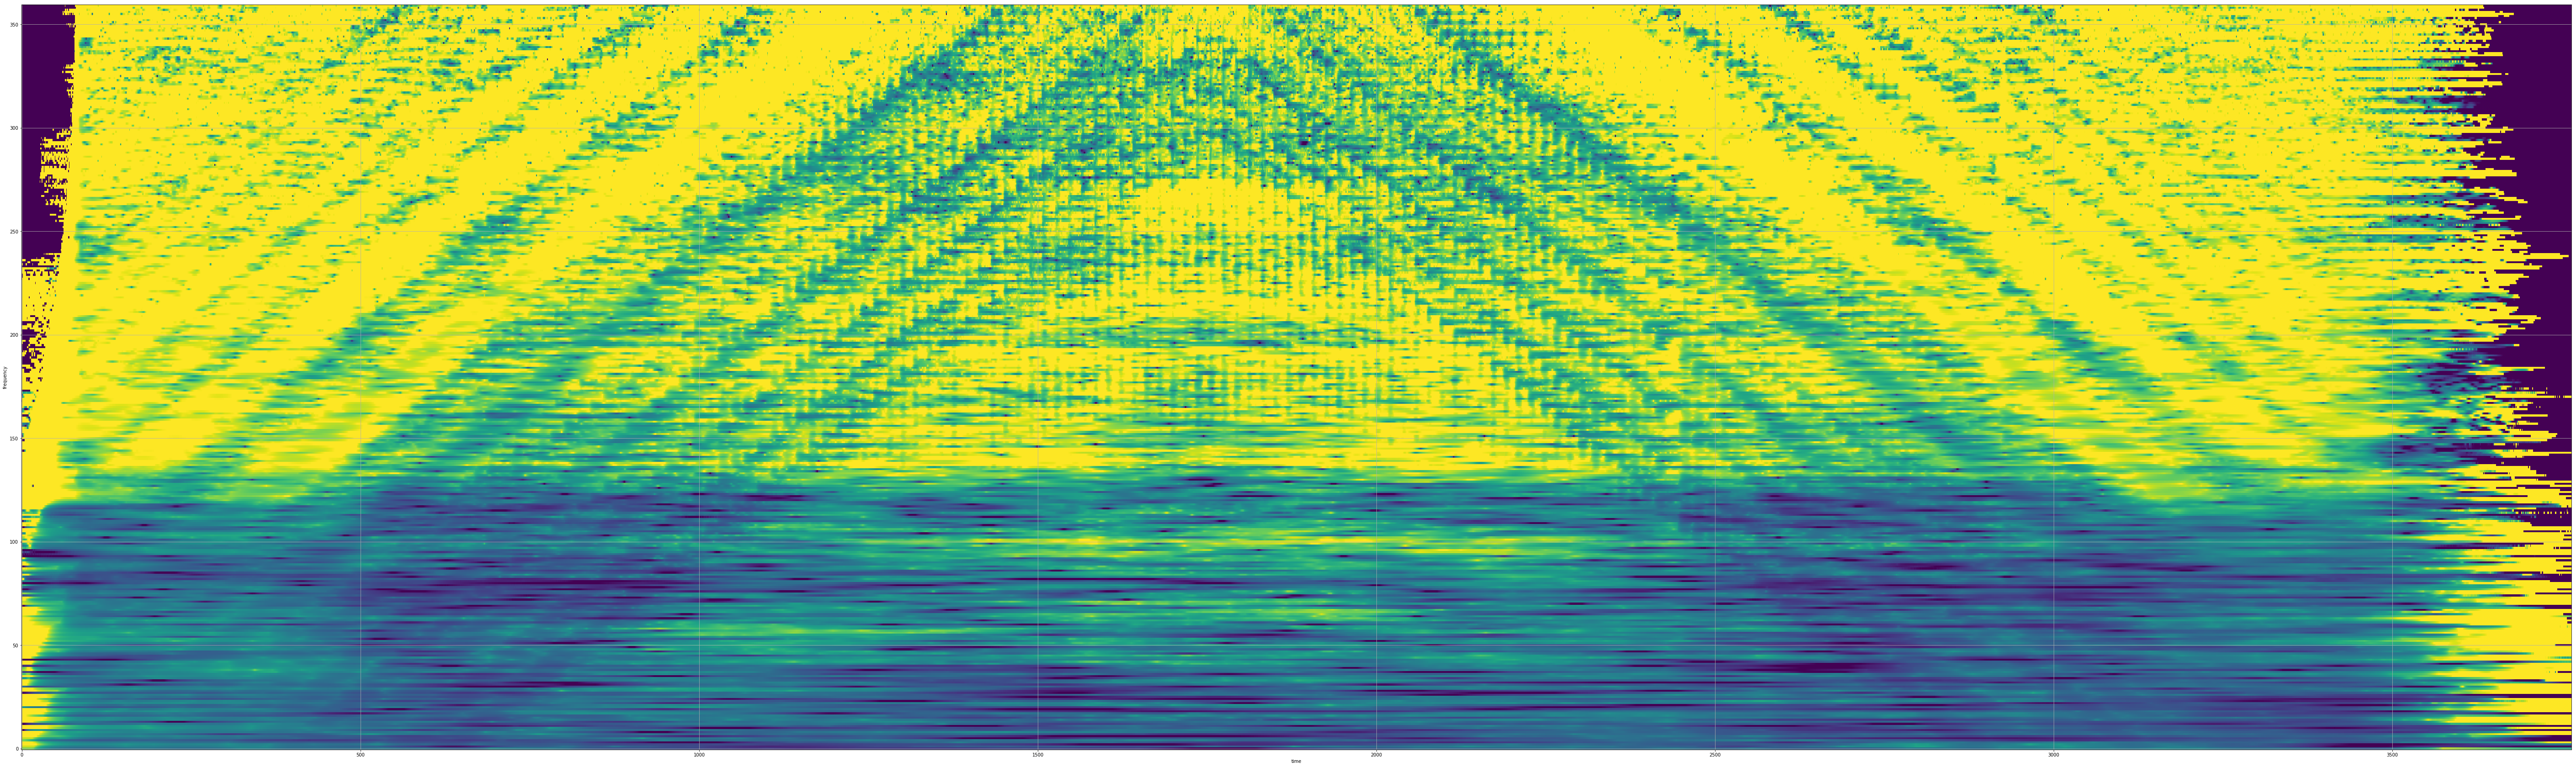

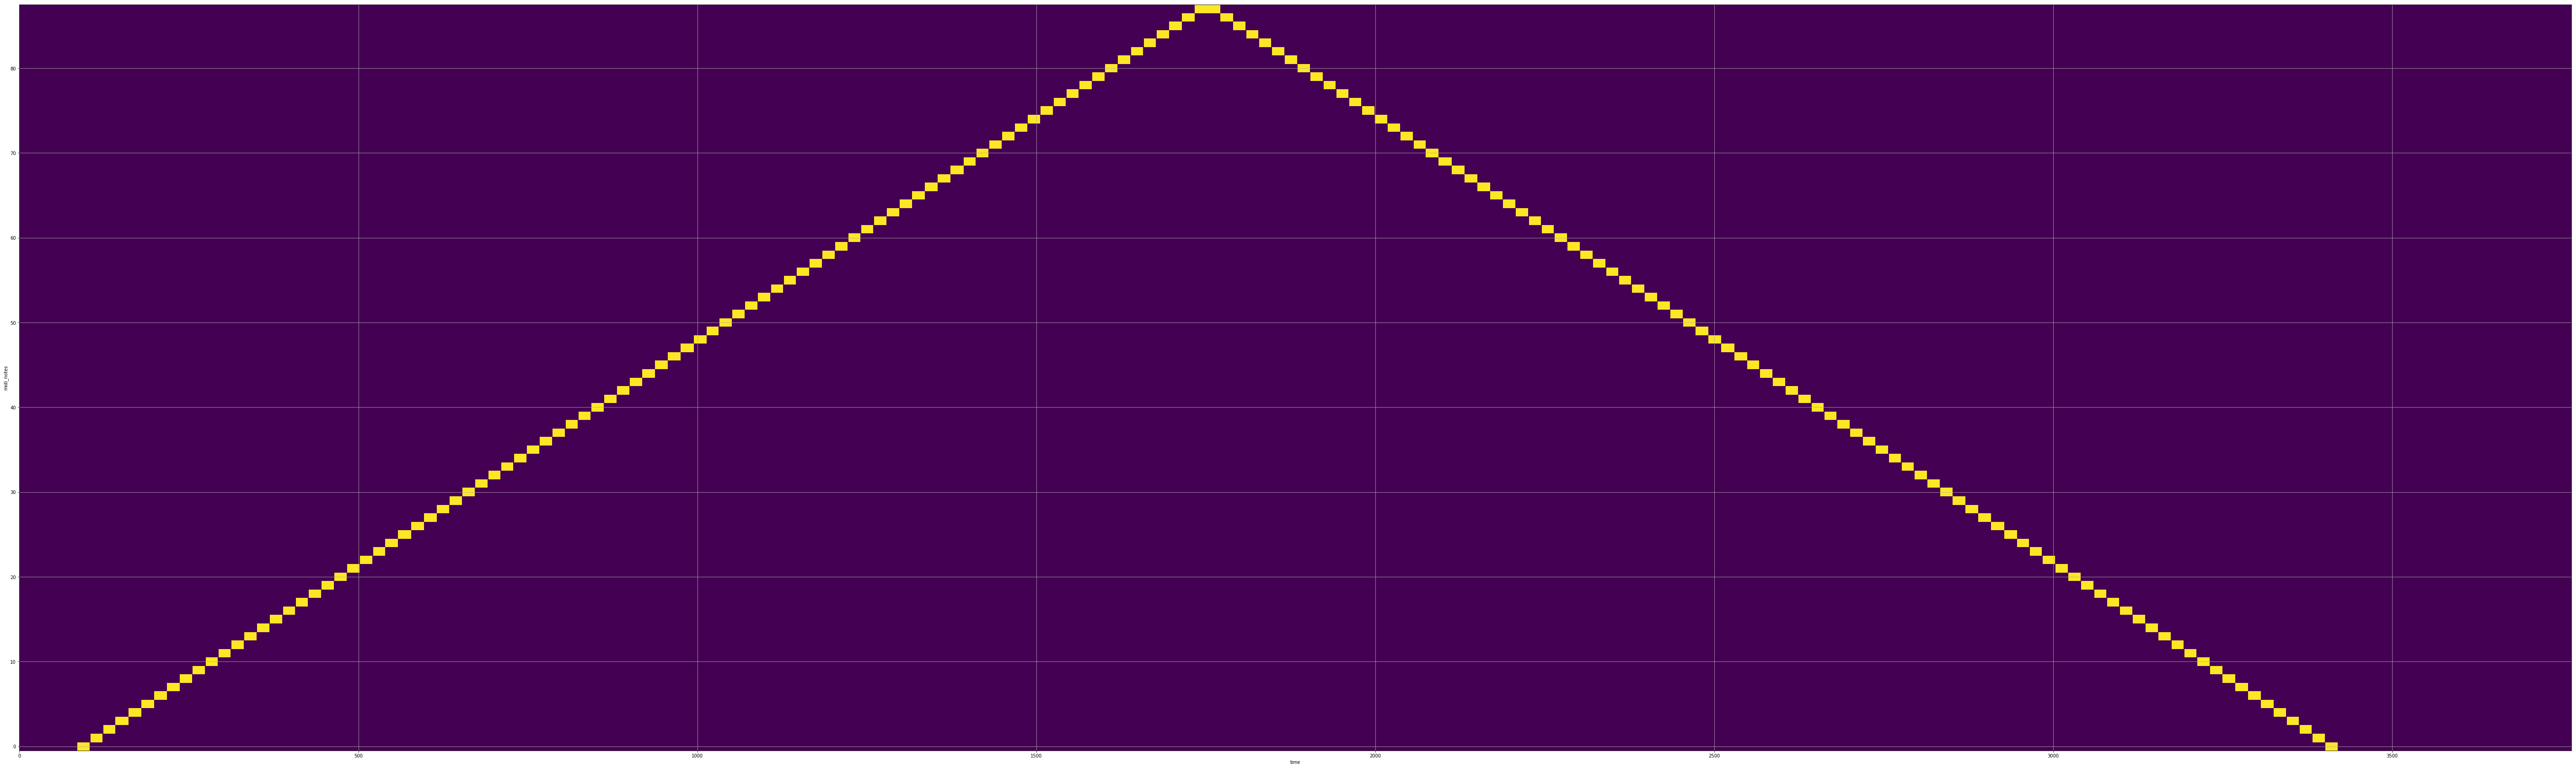

In [68]:
fig = plt.figure(figsize=(100,30))
plt.grid()
plt.imshow(reg_cqt.T,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.show()
fig = plt.figure(figsize=(100,30))
plt.grid()
plt.imshow(expected.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

In [8]:
log_hcqt.shape

(1883, 216, 6)

## Compile Shallow Net

In [9]:
input_shape = (log_hcqt.shape[1], log_hcqt.shape[2])
input_shape

(216, 6)

In [10]:
input = Input(input_shape)
flatten = Flatten()(input)
hidden = Dense(4096, activation='relu')(flatten)
output = Dense(88, activation='sigmoid')(hidden)

shallow_net = Model(inputs=input, outputs=output)

In [11]:
shallow_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 6)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              5312512   
_________________________________________________________________
dense_2 (Dense)              (None, 88)                360536    
Total params: 5,673,048
Trainable params: 5,673,048
Non-trainable params: 0
_________________________________________________________________


In [12]:
print log_hcqt.shape
print expected.shape

(1883, 216, 6)
(1883, 88)


In [30]:
shallow_net.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.1, momentum=0.9),
    metrics=['accuracy', 'mse', 'mae'])

In [31]:
history = shallow_net.fit(
    x=log_hcqt,
    y=expected,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=0.33)

Train on 1261 samples, validate on 622 samples
Epoch 1/10
1261/1261 [==============================] - 3s 2ms/step - loss: 0.2346 - acc: 0.9118 - mean_squared_error: 0.0666 - mean_absolute_error: 0.1512 - val_loss: 0.1081 - val_acc: 0.9916 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0314
Epoch 2/10
1261/1261 [==============================] - 2s 2ms/step - loss: 0.1280 - acc: 0.9889 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0135 - val_loss: 0.1256 - val_acc: 0.9917 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0277
Epoch 3/10
1261/1261 [==============================] - 2s 2ms/step - loss: 0.1073 - acc: 0.9889 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0175 - val_loss: 0.1206 - val_acc: 0.9906 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0460
Epoch 4/10
1261/1261 [==============================] - 2s 2ms/step - loss: 0.0810 - acc: 0.9889 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0276 - val_loss: 0.098

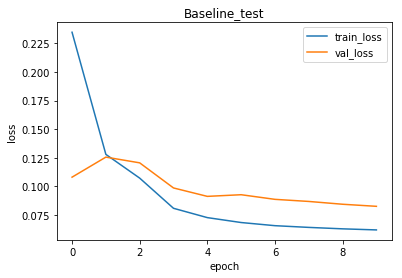

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.title('Baseline_test')
plt.savefig('../results/baseline_test/baseline_test_valloss.png')
plt.show()